In [3]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
import requests
from bs4 import BeautifulSoup
import cv2
import time

In [2]:
def get_image_urls(search_url, max_images=2000):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    
    urls = []
    page = 0

    while len(urls) < max_images:
        response = requests.get(search_url + f'&first={page*50}', headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        image_elements = soup.find_all('a', class_='iusc')

        if not image_elements:
            break

        for img in image_elements:
            if len(urls) >= max_images:
                break
            m = img.get('m')
            if m:
                m = eval(m)
                if 'murl' in m:
                    urls.append(m['murl'])

        page += 1
        time.sleep(1) 
        print(f"Bing: Collected {len(urls)} image URLs so far...")

    return urls

In [73]:
def download_images(urls, folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for i, url in enumerate(urls):
        try:
            img_data = requests.get(url).content
            with open(f'{folder_name}/{i+1}.jpg', 'wb') as handler:
                handler.write(img_data)
        except Exception as e:
            print(f"Could not download {url}: {e}")

In [74]:
urls = {
    'King Cobra': 'https://www.bing.com/images/search?q=king+cobra+images&form=HDRSC4&first=1',
    'Corn Snake': 'https://www.bing.com/images/search?q=corn+snake+images&form=HDRSC4&first=1',
    'Rattlesnake': 'https://www.bing.com/images/search?q=rattlesnake+images&form=HDRSC4&first=1',
    'Python': 'https://www.bing.com/images/search?q=python+snake+images&form=HDRSC4&first=1',
    'Green Tree Python': 'https://www.bing.com/images/search?q=green+tree+python+images&form=HDRSC4&first=1',
    'Boa Constrictor': 'https://www.bing.com/images/search?q=boa+constrictor+images&form=HDRSC4&first=1',
    'Black Mamba': 'https://www.bing.com/images/search?q=black+mamba+images&form=HDRSC4&first=1',
    'Garter Snake': 'https://www.bing.com/images/search?q=garter+snake+images&form=HDRSC4&first=1'
}

In [ ]:
for snake, url in urls.items():
    image_urls = get_image_urls(url, max_images=1200)
    download_images(image_urls, snake)

print("Image downloading complete.")

In [75]:
def resize_images(input_folder, output_folder, size=(128, 128)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        # Read the image
        img = cv2.imread(img_path)
        if img is not None:
            try:
                resized_img = cv2.resize(img, size)
                cv2.imwrite(os.path.join(output_folder, filename), resized_img)
            except Exception as e:
                print(f"Could not resize {img_path}: {e}")

In [ ]:
for snake in urls.keys():
    resize_images(snake, f'resized_{snake}')  # Creating dataset

print("Image standardization complete.")

In [4]:
def split_dataset(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    classes = os.listdir(data_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for split in ['train', 'val', 'test']:
        for class_name in classes:
            split_dir = os.path.join(output_dir, split, class_name)
            if not os.path.exists(split_dir):
                os.makedirs(split_dir)
    
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        images = os.listdir(class_dir)
        
        train_images, temp_images = train_test_split(images, test_size=(1 - train_ratio))
        val_size = val_ratio / (1 - train_ratio)
        val_images, test_images = train_test_split(temp_images, test_size=1 - val_size)
        
        for img in train_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'train', class_name, img))
        for img in val_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'val', class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'test', class_name, img))

data_dir = 'resized_snakes'
output_dir = 'dataset'
split_dataset(data_dir, output_dir)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
input_shape = (128, 128, 3)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 7933 images belonging to 8 classes.
Found 4436 images belonging to 8 classes.
Found 4445 images belonging to 8 classes.


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

In [8]:
import tensorflow as tf
from sklearn.metrics import average_precision_score

class MAPMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_average_precision', **kwargs):
        super(MAPMetric, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_labels = []
        self.pred_labels = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes)
        self.true_labels.append(y_true_one_hot)
        self.pred_labels.append(y_pred)

    def result(self):
        true_labels = tf.concat(self.true_labels, axis=0)
        pred_labels = tf.concat(self.pred_labels, axis=0)
        true_labels_np = true_labels.numpy()
        pred_labels_np = pred_labels.numpy()
        return tf.py_function(average_precision_score, (true_labels_np, pred_labels_np, 'macro'), tf.float32)

    def reset_states(self):
        self.true_labels = []
        self.pred_labels = []

num_classes = len(train_generator.class_indices)
map_metric = MAPMetric(num_classes=num_classes)

In [9]:
def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
def create_densenet_model(input_shape, num_classes):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def create_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
input_shape = (128, 128, 3)
num_classes = len(train_generator.class_indices)

resnet_model = create_resnet_model(input_shape, num_classes)
densenet_model = create_densenet_model(input_shape, num_classes)
mobilenet_model = create_mobilenet_model(input_shape, num_classes)

C:\Users\aminy\anaconda3\Lib\site-packages\keras\src\applications\mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [64]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5)
]

models = {
    'ResNet50': resnet_model,
    'DenseNet121': densenet_model,
    'MobileNetV3': mobilenet_model
}

history = {}
training_times = {}

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    history[name] = model.fit(
        train_generator,
        epochs=50,
        validation_data=val_generator,
        callbacks=callbacks
    )
    training_times[name] = time.time() - start_time
    model.save(f'{name}.keras')
    print(f"{name} training complete.")

Training ResNet50...
Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 125s 513ms/step - accuracy: 0.2697 - loss: 2.1147 - val_accuracy: 0.2908 - val_loss: 2.5566 - learning_rate: 0.0010
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 116s 509ms/step - accuracy: 0.3884 - loss: 1.6853 - val_accuracy: 0.2534 - val_loss: 3.2961 - learning_rate: 0.0010
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 112s 489ms/step - accuracy: 0.4120 - loss: 1.6107 - val_accuracy: 0.3787 - val_loss: 2.0048 - learning_rate: 0.0010
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 117s 510ms/step - accuracy: 0.4305 - loss: 1.5734 - val_accuracy: 0.3129 - val_loss: 2.4715 - learning_rate: 0.0010
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 114s 501ms/step - accuracy: 0.4451 - loss: 1.5359 - val_accuracy: 0.3368 - val_loss: 2.0949 - learning_rate: 0.0010
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 113s 497ms/step - accuracy: 0.4460 - loss: 1.5356 - val_accuracy: 0.4166 - val_loss: 1.8788 - learning_rate: 0.0010
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 113

In [66]:
from sklearn.metrics import average_precision_score
import numpy as np
import tensorflow as tf

def evaluate_model(model, test_generator, num_classes):
    y_true = []
    y_pred = []
    for i in range(len(test_generator)):
        images, labels = test_generator[i]
        preds = model.predict(images)
        y_true.extend(labels)
        y_pred.extend(preds)
        if i % 10 == 0:  # Print progress every 10 batches
            print(f"Processed {i + 1}/{len(test_generator)} batches")

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = np.mean(np.argmax(y_pred, axis=1) == y_true)
    mAP = average_precision_score(tf.one_hot(y_true, depth=num_classes).numpy(), y_pred, average='macro')
    
    return accuracy, mAP

num_classes = len(train_generator.class_indices)

for name, model in models.items():
    print(f"Evaluating {name}...")
    accuracy, mAP = evaluate_model(model, test_generator, num_classes)
    print(f"{name} - Accuracy: {accuracy}, mAP: {mAP}, Training Time: {training_times[name]}")

Evaluating ResNet50...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Processed 1/70 batches
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Processed 11/70 batches
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Processed 21/70 batches
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━

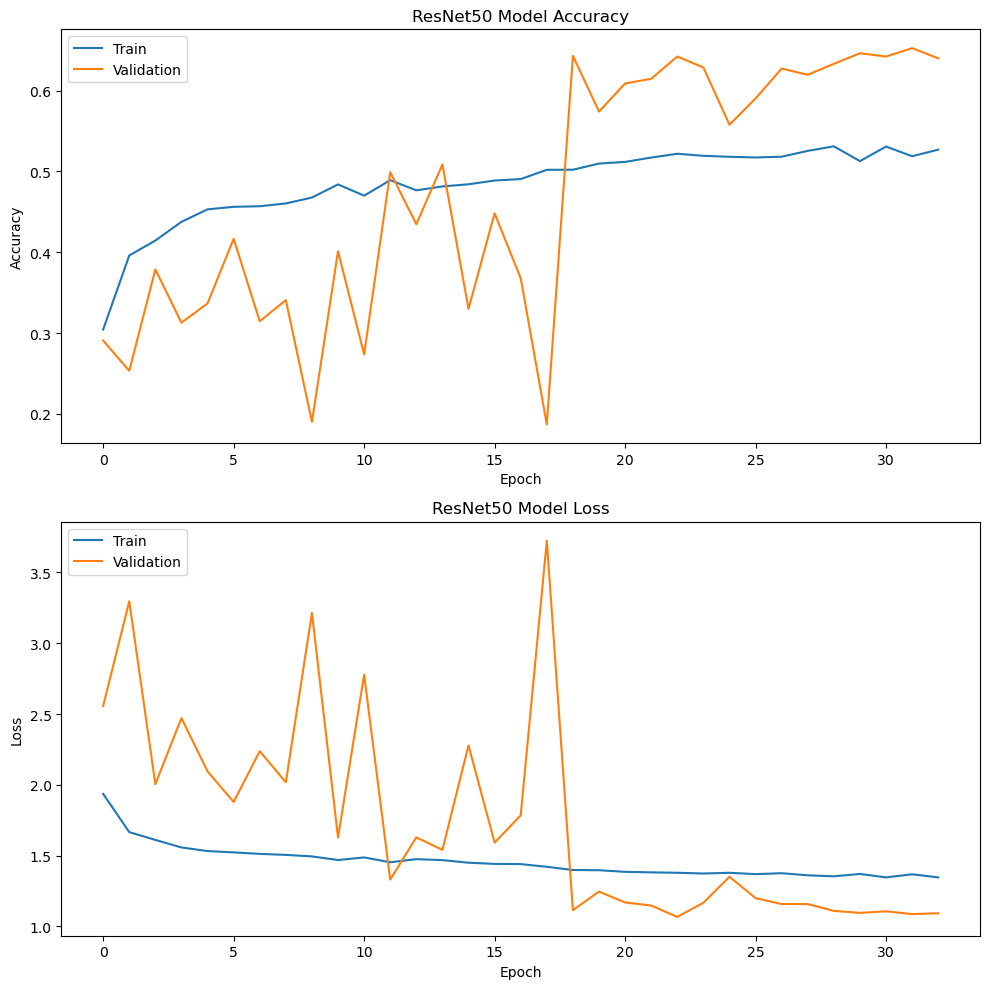

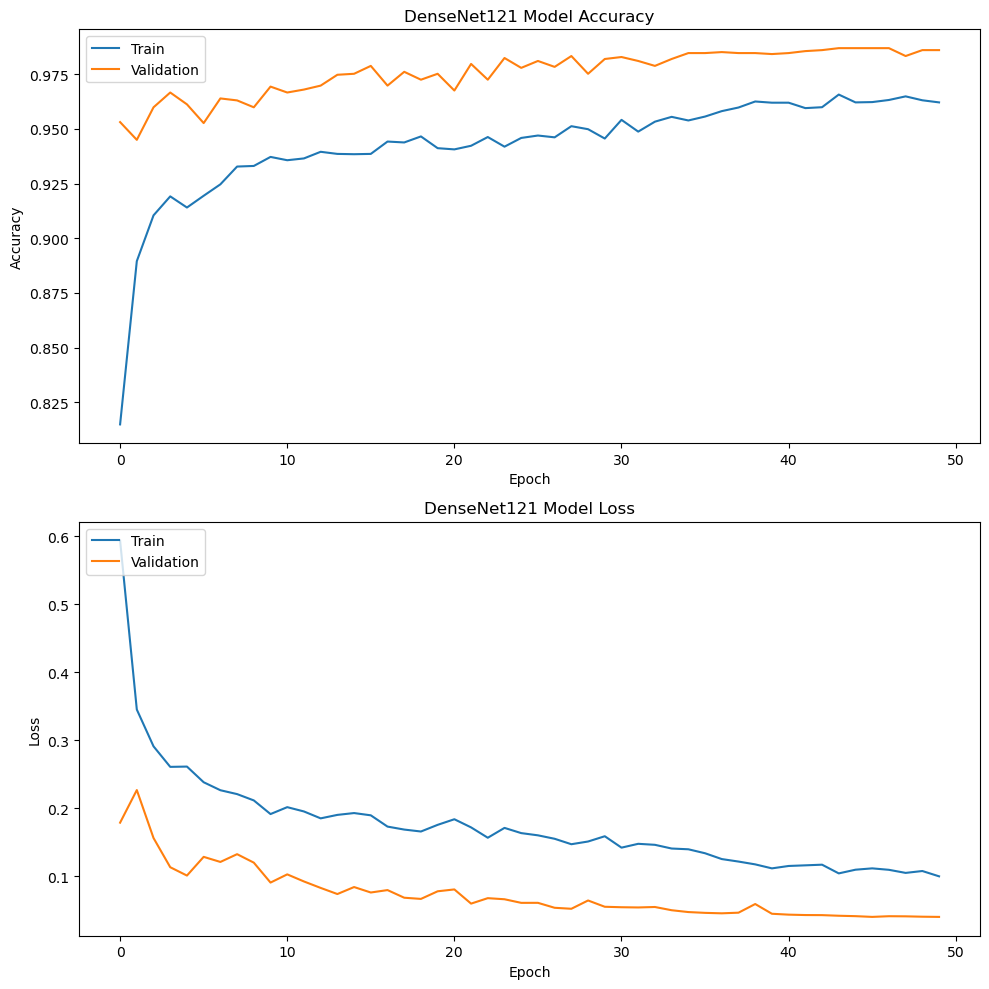

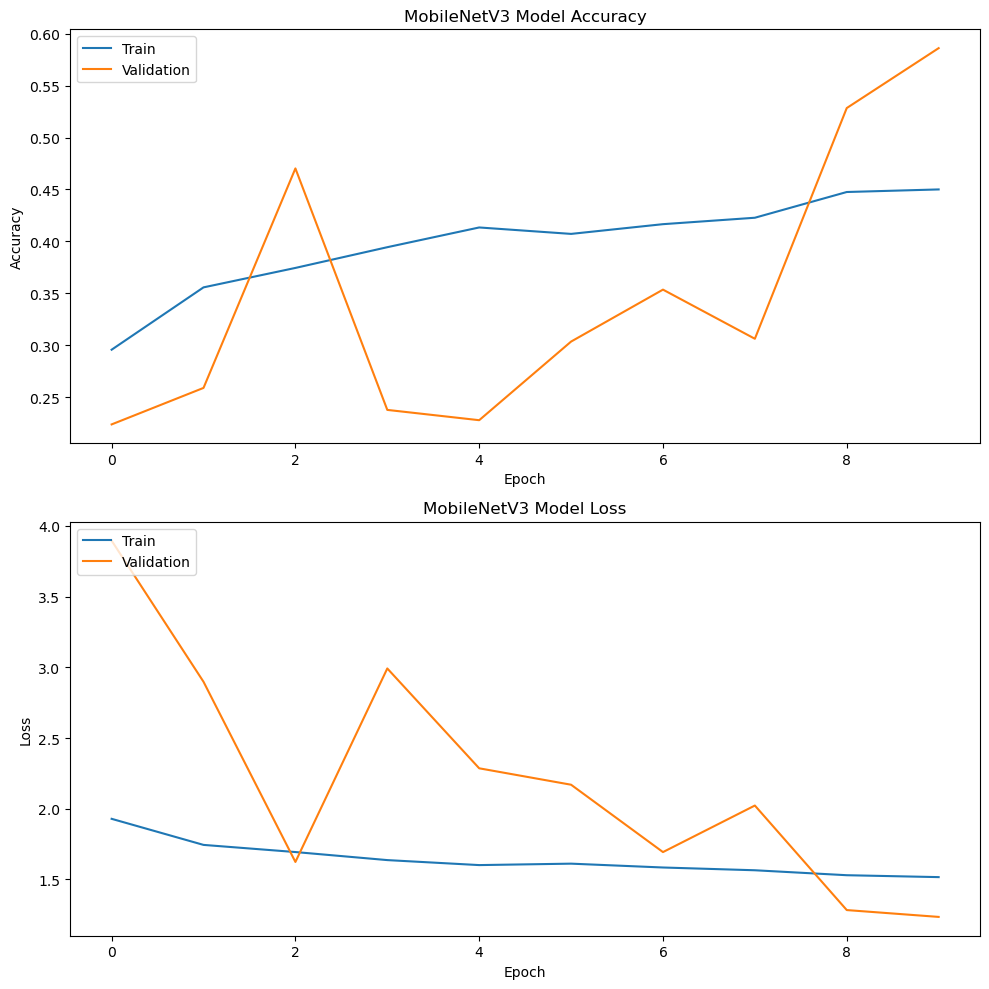

In [67]:
import matplotlib.pyplot as plt

def plot_history(histories):
    for name, history in histories.items():
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        
        axs[0].plot(history.history['accuracy'])
        axs[0].plot(history.history['val_accuracy'])
        axs[0].set_title(f'{name} Model Accuracy')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].legend(['Train', 'Validation'], loc='upper left')
        
        axs[1].plot(history.history['loss'])
        axs[1].plot(history.history['val_loss'])
        axs[1].set_title(f'{name} Model Loss')
        axs[1].set_ylabel('Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

plot_history(history)

Confusion Matrix for ResNet50


C:\Users\aminy\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 360ms/step


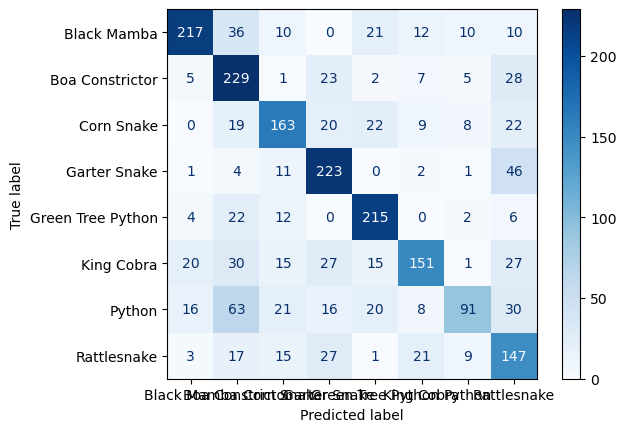

Confusion Matrix for DenseNet121
70/70 ━━━━━━━━━━━━━━━━━━━━ 36s 437ms/step


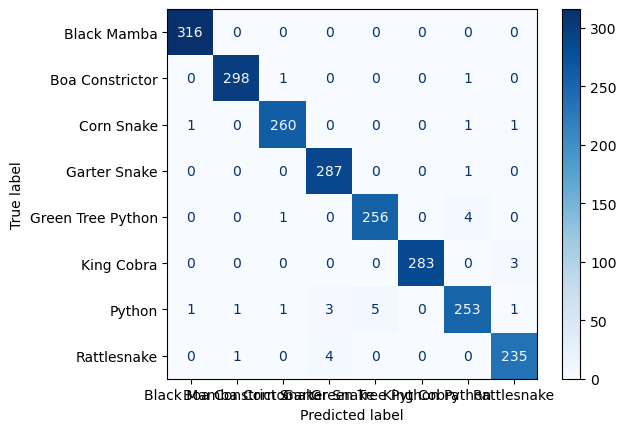

Confusion Matrix for MobileNetV3
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step


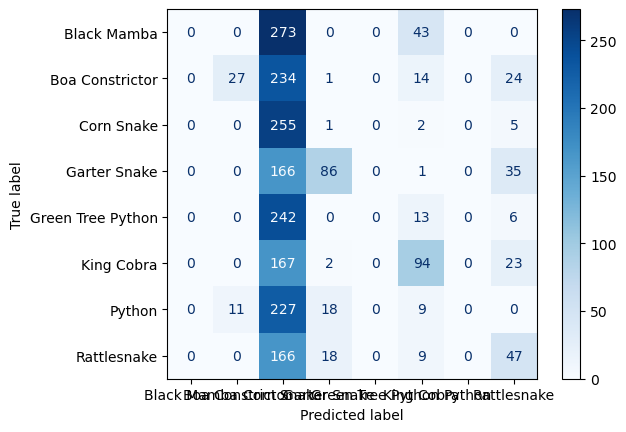

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, generator, class_names):
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

class_names = list(train_generator.class_indices.keys())

for name, model in models.items():
    print(f"Confusion Matrix for {name}")
    plot_confusion_matrix(model, test_generator, class_names)

In [18]:
# Conclusion 1
# After evaluating the three models (ResNet50, DenseNet121, and MobileNetV3), we can draw the following conclusions based on their performance metrics and training times:

# ResNet50:
# Accuracy: 64.71%
# mAP: 72.55%
# Training Time: 3678.59 seconds

# DenseNet121:
# Accuracy: 98.60%
# mAP: 99.80%
# Training Time: 5234.98 seconds

# (With EarlyStopping, only 10 epochs) MobileNetV3:
# Accuracy: 22.94%
# mAP: 39.31%
# Training Time: 314.17 seconds

# Refer below for updated MobileNet training.

In [13]:
callbacks = [
    ReduceLROnPlateau(patience=5)
]

models = {
    'MobileNetV3': mobilenet_model
}

history = {}
training_times = {}

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    history[name] = model.fit(
        train_generator,
        epochs=50,
        validation_data=val_generator,
        callbacks=callbacks
    )
    training_times[name] = time.time() - start_time
    model.save(f'{name}.keras')
    print(f"{name} training complete.")

Training MobileNetV3...
Epoch 1/50


C:\Users\aminy\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 88s 315ms/step - accuracy: 0.2630 - loss: 2.0605 - val_accuracy: 0.2304 - val_loss: 3.6576 - learning_rate: 0.0010
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.3400 - loss: 1.7806 - val_accuracy: 0.3122 - val_loss: 2.2403 - learning_rate: 0.0010
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 37s 144ms/step - accuracy: 0.3674 - loss: 1.7111 - val_accuracy: 0.2554 - val_loss: 2.1735 - learning_rate: 0.0010
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.3872 - loss: 1.6384 - val_accuracy: 0.3753 - val_loss: 1.8830 - learning_rate: 0.0010
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.4171 - loss: 1.6028 - val_accuracy: 0.2969 - val_loss: 2.1640 - learning_rate: 0.0010
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.4074 - loss: 1.6143 - val_accuracy: 0.2610 - val_loss: 2.7028 - learning_rate: 0.0010
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 38s 148ms/step - accuracy: 0.4159 - loss:

In [14]:
from sklearn.metrics import average_precision_score
import numpy as np
import tensorflow as tf

def evaluate_model(model, test_generator, num_classes):
    y_true = []
    y_pred = []
    for i in range(len(test_generator)):
        images, labels = test_generator[i]
        preds = model.predict(images)
        y_true.extend(labels)
        y_pred.extend(preds)
        if i % 10 == 0:  # Print progress every 10 batches
            print(f"Processed {i + 1}/{len(test_generator)} batches")

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = np.mean(np.argmax(y_pred, axis=1) == y_true)
    mAP = average_precision_score(tf.one_hot(y_true, depth=num_classes).numpy(), y_pred, average='macro')
    
    return accuracy, mAP

num_classes = len(train_generator.class_indices)

for name, model in models.items():
    print(f"Evaluating {name}...")
    accuracy, mAP = evaluate_model(model, test_generator, num_classes)
    print(f"{name} - Accuracy: {accuracy}, mAP: {mAP}, Training Time: {training_times[name]}")

Evaluating MobileNetV3...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Processed 1/139 batches
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Processed 11/139 batches
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Processed 21/139 batches
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

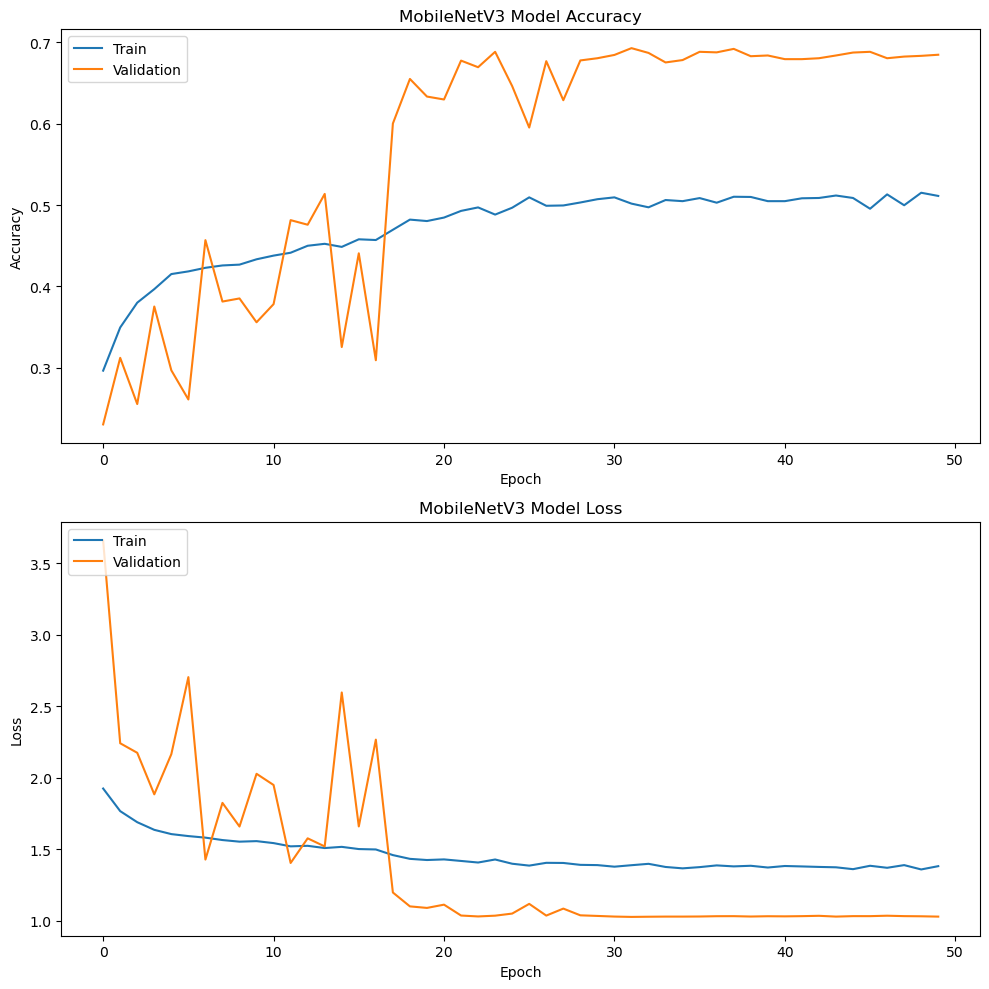

In [15]:
import matplotlib.pyplot as plt

def plot_history(histories):
    for name, history in histories.items():
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        
        axs[0].plot(history.history['accuracy'])
        axs[0].plot(history.history['val_accuracy'])
        axs[0].set_title(f'{name} Model Accuracy')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].legend(['Train', 'Validation'], loc='upper left')
        
        axs[1].plot(history.history['loss'])
        axs[1].plot(history.history['val_loss'])
        axs[1].set_title(f'{name} Model Loss')
        axs[1].set_ylabel('Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

plot_history(history)

Confusion Matrix for MobileNetV3


C:\Users\aminy\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step


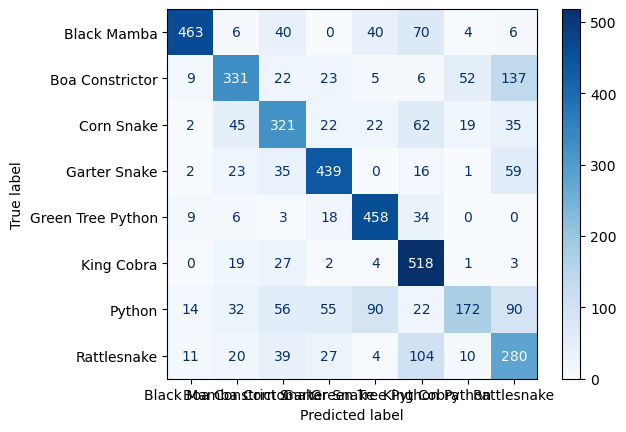

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, generator, class_names):
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

class_names = list(train_generator.class_indices.keys())

for name, model in models.items():
    print(f"Confusion Matrix for {name}")
    plot_confusion_matrix(model, test_generator, class_names)

In [19]:
# Final Conclusion
# After evaluating the three models (ResNet50, DenseNet121, and MobileNetV3), we can draw the following conclusions based on their performance metrics and training times:

# ResNet50:
# Accuracy: 64.71%
# mAP: 72.55%
# Training Time: 3678.59 seconds (~1 hour)

# DenseNet121:
# Accuracy: 98.60%
# mAP: 99.80%
# Training Time: 5234.98 seconds (1 hour ~30 minutes)

# (Without EarlyStopping, full 50 epochs) MobileNetV3:
# Accuracy: 67.09%
# mAP: 70.93%
# Training Time: 1885.62 seconds (~31 minutes)

# Based on the results, DenseNet121 performed the best in accuracy and mAP. It achieved the highest scores in both metrics. However, do note that it had the longest training time.

# In conclusion, DenseNet121 is the most suitable if the priority is achieving the highest performance. If training time is to be considered, then MobileNetV3 offers the shortest training time but with lower but decent performance.